# Simulation of HYSPEC powder experiment

In [33]:
# some goodies
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np, histogram.hdf as hh, histogram as H

## Create workflow

In [2]:
# Change me
workdir = "/SNS/users/lj7/simulations/HYSPEC/powder-demo"
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/simulations/HYSPEC/powder-demo


In [3]:
!mcvine workflow powder --instrument=hyspec --sample=V --workdir=mysim

In [4]:
!ls mysim/

beam	    debug-scatter  README.md   sampleassembly  sss	test-scatter
create-nxs  Makefile	   reduce2iqe  scatter	       sss.pml


## Beam simulation

In [5]:
# change to beam sim directory
%cd {workdir}/mysim/beam

/SNS/users/lj7/simulations/HYSPEC/powder-demo/mysim/beam


In [6]:
# show the simulation script
!cat run-beam.sh

#!/usr/bin/env bash
# run 
#   mcvine instruments hyspec beam -h 
# for more options
#
mcvine instruments hyspec beam --keep-in-cache --use-cache --ncount=1e8



In [7]:
# modify the simulation script (desired incident energy, neutron count)

In [12]:
%%file run-beam.sh
#!/usr/bin/env bash

mcvine instruments hyspec beam --keep-in-cache --use-cache \
    --E=7.5 --Emin=5 --Emax=10 --fermi_nu=180. \
    --ncount=1e9  --nodes=20

Overwriting run-beam.sh


In [ ]:
# run simulation
!./run-beam.sh >log.run

After the beam simulation is done
* The main output are in the new folder "out".
* The ".h5" files are histograms of various sorts.
* The "neutron" file is the simulated neutrons of the beam incident on the sample

In [16]:
!ls out

ienergy.h5  ix_divx.h5	ix_y.h5     iy_divy.h5	props.json
itof.h5     ix_divy.h5	iy_divx.h5  neutrons	rank0-step0


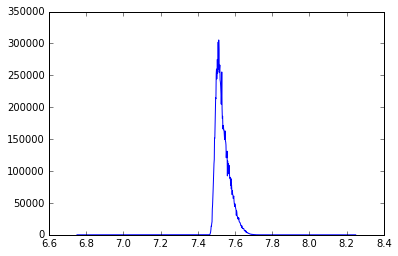

In [19]:
# plot I(E) spectrum
ie = hh.load("out/ienergy.h5")
plt.plot(ie.energy, ie.I)

## Scattering simulation and reduction

The simulation directory contains a Makefile and various scripts to make it easy to run the simulation and analsysis.

In [21]:
%cd {workdir}/mysim
!ls

/SNS/users/lj7/simulations/HYSPEC/powder-demo/mysim
beam	    debug-scatter  README.md   sampleassembly  sss	test-scatter
create-nxs  Makefile	   reduce2iqe  scatter	       sss.pml


In [25]:
# Modify Makefile to set some parameters

In [28]:
%%file Makefile
# -*- Makefile -*-

# *** modifye the following if running mannualy ***
# *** or use command line to change them.       ***
INSTRUMENT=hyspec
NCOUNT=1000000.0
BUFFER_SIZE=100000
NODES=10
QAXIS=0 6 0.05
DETECTOR_VESSEL_ANGLE=-45

# default rule: we want I(Q,E)
all: IQE

# clean up
clean:
	rm -rf out work-* log.* *~ *.h5 *.nxs

# this rule restore this directory back to the original state of template
# don't do this unless you know what you are doing
restore-template: clean
	rm -f beam
	rm -rf sampleassembly
	rm -rf *.nxs *.h5


plot-iqe: IQE
	plothist --min=0 iqe.h5

# IQE comes from iqe histogram file
IQE: iqe.h5

# iqe histogram comes from reduction of simulated event mode nexus file
iqe.h5: sim.nxs
	INSTRUMENT=$(INSTRUMENT) QAXIS="$(QAXIS)" ./reduce2iqe >log.reduce 2>&1

# nexus file comes from collecting scattered neutrons at the detector system
sim.nxs: out/scattered-neutrons
	DETECTOR_VESSEL_ANGLE=${DETECTOR_VESSEL_ANGLE} INSTRUMENT=$(INSTRUMENT) NODES=$(NODES) ./create-nxs </dev/null >log.create-nxs 2>&1

# scattered neutrons comes from simulation of scattering of incident beam by sample assembly
out/scattered-neutrons: beam sampleassembly sampleassembly/*
	NCOUNT=$(NCOUNT) BUFFER_SIZE=$(BUFFER_SIZE) NODES=$(NODES) ./scatter </dev/null >log.scatter 2>&1

# Required inputs
beam:
	@echo "** Missing incident beam"
	@echo "** Please create a symbolic link to the incident beam"
	@echo "** For example: ln -s ~/simulations/ARCS/beam/688meV beam"
	exit 1

sampleassembly:
	@echo "** Missing sample assembly"
	@echo "** Please create a sampleassembly directory."
	@echo "** You can do this by copying, for example: cp -a ~/simulations/ARCS/He4/sim/template/sampleassembly ."
	exit 1


Overwriting Makefile


In [29]:
# run simulation and reduction
!chmod +x scatter sss reduce2iqe create-nxs
!make

NCOUNT=1000000.0 BUFFER_SIZE=100000 NODES=10 ./scatter </dev/null >log.scatter 2>&1
DETECTOR_VESSEL_ANGLE=-45 INSTRUMENT=hyspec NODES=10 ./create-nxs </dev/null >log.create-nxs 2>&1
INSTRUMENT=hyspec QAXIS="0 8 0.1" ./reduce2iqe >log.reduce 2>&1


plot z in (0, 1e-06)


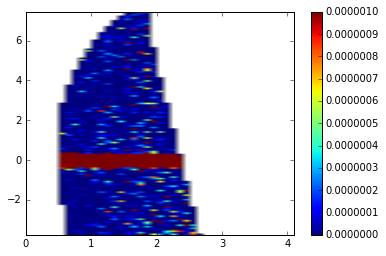

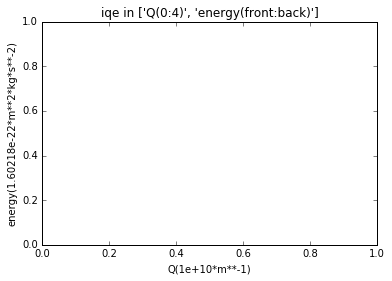

In [35]:
iqe = hh.load("iqe.h5")
H.plot(iqe[(0,4), ()], min=0, max=1e-6)